In [ ]:
import tensorflow as tf
import tensorflow_datasets as tfds
from tensorflow.keras import layers, Model
import matplotlib.pyplot as plt

In [ ]:
def preprocess(datapoint):
    image = tf.image.resize(datapoint['image'], (IMG_SIZE, IMG_SIZE))
    mask = tf.image.resize(datapoint['segmentation_mask'], (IMG_SIZE, IMG_SIZE))

    # Convert mask classes: pet=2 -> 1, others -> 0 (binary segmentation)
    mask = tf.where(mask == 2, 1, 0)
    mask = tf.cast(mask, tf.float32)

    image = tf.cast(image, tf.float32) / 255.0
    return image, mask

In [ ]:
def conv_block(x, filters):
    x = layers.Conv2D(filters, 3, padding='same', activation='relu')(x)
    x = layers.Conv2D(filters, 3, padding='same', activation='relu')(x)
    return x



In [ ]:
def upsample_concat(x, skip):
    x = layers.UpSampling2D()(x)
    x = layers.Concatenate()([x, skip])
    return x

In [1]:

def build_unet(input_shape=(IMG_SIZE, IMG_SIZE, 3)):
    base_model = tf.keras.applications.ResNet50(include_top=False, weights='imagenet', input_shape=input_shape)

    skip1 = base_model.get_layer("conv1_relu").output
    skip2 = base_model.get_layer("conv2_block3_out").output
    skip3 = base_model.get_layer("conv3_block4_out").output
    skip4 = base_model.get_layer("conv4_block6_out").output

    x = base_model.output

    x = upsample_concat(x, skip4)
    x = conv_block(x, 512)

    x = upsample_concat(x, skip3)
    x = conv_block(x, 256)

    x = upsample_concat(x, skip2)
    x = conv_block(x, 128)

    x = upsample_concat(x, skip1)
    x = conv_block(x, 64)

    x = layers.UpSampling2D()(x)
    outputs = layers.Conv2D(1, 1, activation='sigmoid')(x)

    return Model(inputs=base_model.input, outputs=outputs)

In [ ]:
def show_predictions(dataset, num=3):
    for images, masks in dataset.take(1):
        preds = model.predict(images)
        preds = tf.where(preds>0.5, 1.0, 0.0)

        for i in range(num):
            plt.figure(figsize=(12,4))
            plt.subplot(1,3,1)
            plt.title("Image")
            plt.imshow(images[i])
            plt.axis('off')

            plt.subplot(1,3,2)
            plt.title("True Mask")
            plt.imshow(masks[i][:,:,0], cmap='gray')
            plt.axis('off')

            plt.subplot(1,3,3)
            plt.title("Predicted Mask")
            plt.imshow(preds[i][:,:,0], cmap='gray')
            plt.axis('off')

            plt.show()

Dl Completed...: 0 url [00:00, ? url/s]

Dl Size...: 0 MiB [00:00, ? MiB/s]

Extraction completed...: 0 file [00:00, ? file/s]

Generating splits...:   0%|          | 0/2 [00:00<?, ? splits/s]

Generating train examples...: 0 examples [00:00, ? examples/s]

Shuffling /root/tensorflow_datasets/oxford_iiit_pet/incomplete.1UI3RL_4.0.0/oxford_iiit_pet-train.tfrecord*...…

Generating test examples...: 0 examples [00:00, ? examples/s]

Shuffling /root/tensorflow_datasets/oxford_iiit_pet/incomplete.1UI3RL_4.0.0/oxford_iiit_pet-test.tfrecord*...:…

Dataset oxford_iiit_pet downloaded and prepared to /root/tensorflow_datasets/oxford_iiit_pet/4.0.0. Subsequent calls will reuse this data.
94765736/94765736 ━━━━━━━━━━━━━━━━━━━━ 5s 0us/step


Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer         │ (None, 128, 128,  │          0 │ -                 │
│ (InputLayer)        │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1_pad           │ (None, 134, 134,  │          0 │ input_layer[0][0] │
│ (ZeroPadding2D)     │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1_conv (Conv2D) │ (None, 64, 64,    │      9,472 │ conv1_pad[0][0]   │
│                     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1_bn            │ (None, 64, 64,    │        256 │ conv1_conv[0][0]  │
│ (BatchNormalizatio… │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1_relu          │ (None, 64, 64,    │          0 │ conv1_bn[0][0]    │
│ (Activation)        │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ pool1_pad           │ (None, 66, 66,    │          0 │ conv1_relu[0][0]  │
│ (ZeroPadding2D)     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ pool1_pool          │ (None, 32, 32,    │          0 │ pool1_pad[0][0]   │
│ (MaxPooling2D)      │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_1_conv │ (None, 32, 32,    │      4,160 │ pool1_pool[0][0]  │
│ (Conv2D)            │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_1_bn   │ (None, 32, 32,    │        256 │ conv2_block1_1_c… │
│ (BatchNormalizatio… │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_1_relu │ (None, 32, 32,    │          0 │ conv2_block1_1_b… │
│ (Activation)        │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_2_conv │ (None, 32, 32,    │     36,928 │ conv2_block1_1_r… │
│ (Conv2D)            │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_2_bn   │ (None, 32, 32,    │        256 │ conv2_block1_2_c… │
│ (BatchNormalizatio… │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_2_relu │ (None, 32, 32,    │          0 │ conv2_block1_2_b… │
│ (Activation)        │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_0_conv │ (None, 32, 32,    │     16,640 │ pool1_pool[0][0]  │
│ (Conv2D)            │ 256)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_3_conv │ (None, 32, 32,    │     16,640 │ conv2_block1_2_r… │
│ (Conv2D)            │ 256)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_0_bn   │ (None, 32, 32,    │      1,024 │ conv2_block1_0_c… │
│ (BatchNormalizatio… │ 256)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_3_bn   │ (None, 32, 32,    │      1,024 │ conv2_block1_3_c

 Total params: 43,938,625 (167.61 MB)

 Trainable params: 43,885,505 (167.41 MB)

 Non-trainable params: 53,120 (207.50 KB)

Epoch 1/10
115/115 ━━━━━━━━━━━━━━━━━━━━ 134s 476ms/step - accuracy: 0.6409 - loss: 3.2882 - val_accuracy: 0.5731 - val_loss: 2.1984
Epoch 2/10
115/115 ━━━━━━━━━━━━━━━━━━━━ 40s 350ms/step - accuracy: 0.8914 - loss: 0.2628 - val_accuracy: 0.7192 - val_loss: 0.6523
Epoch 3/10
115/115 ━━━━━━━━━━━━━━━━━━━━ 40s 346ms/step - accuracy: 0.9240 - loss: 0.1890 - val_accuracy: 0.5995 - val_loss: 1.4838
Epoch 4/10
115/115 ━━━━━━━━━━━━━━━━━━━━ 42s 351ms/step - accuracy: 0.9362 - loss: 0.1601 - val_accuracy: 0.7476 - val_loss: 0.6270
Epoch 5/10
115/115 ━━━━━━━━━━━━━━━━━━━━ 40s 351ms/step - accuracy: 0.9482 - loss: 0.1309 - val_accuracy: 0.6835 - val_loss: 1.2955
Epoch 6/10
115/115 ━━━━━━━━━━━━━━━━━━━━ 40s 344ms/step - accuracy: 0.9540 - loss: 0.1145 - val_accuracy: 0.8613 - val_loss: 0.4188
Epoch 7/10
115/115 ━━━━━━━━━━━━━━━━━━━━ 41s 355ms/step - accuracy: 0.9558 - loss: 0.1094 - val_accuracy: 0.9021 - val_loss: 0.2600
Epoch 8/10
115/115 ━━━━━━━━━━━━━━━━━━━━ 41s 354ms/step - accuracy: 0.9566 - loss: 

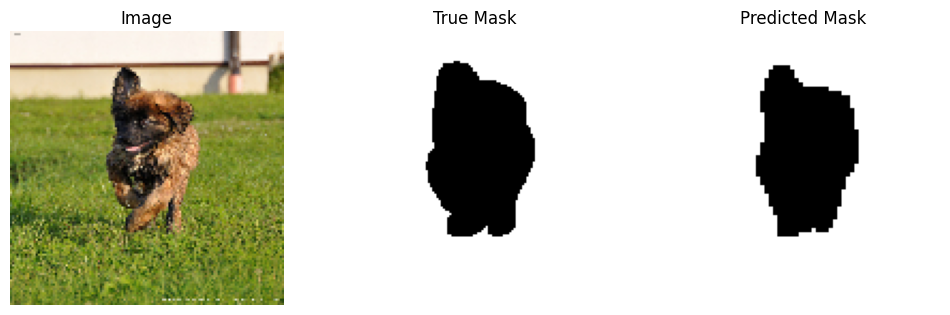

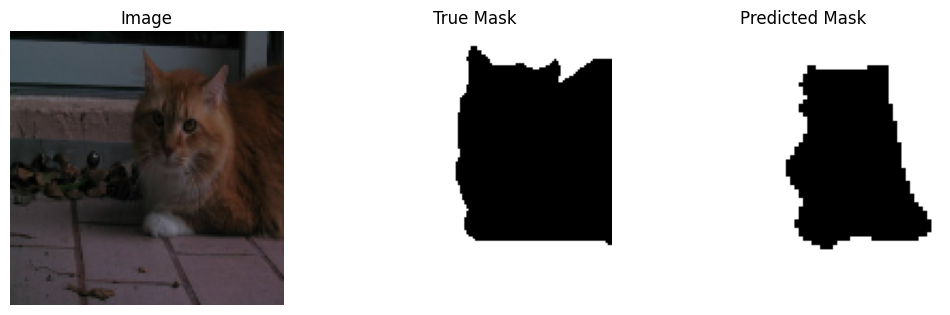

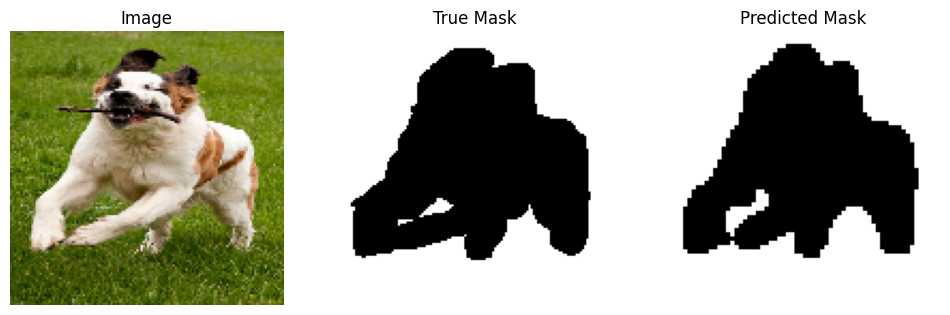

In [1]:
dataset, info = tfds.load('oxford_iiit_pet:4.0.0', with_info=True)
train_ds = dataset['train']
test_ds = dataset['test']

train = train_ds.map(preprocess, num_parallel_calls=AUTOTUNE)
test = test_ds.map(preprocess, num_parallel_calls=AUTOTUNE)

train = train.cache().shuffle(1000).batch(BATCH_SIZE).prefetch(AUTOTUNE)
test = test.batch(BATCH_SIZE).prefetch(AUTOTUNE)

IMG_SIZE = 128
BATCH_SIZE = 32
AUTOTUNE = tf.data.AUTOTUNE
model = build_unet()
model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])
model.summary()

EPOCHS = 10
model.fit(train, epochs=EPOCHS, validation_data=test)



show_predictions(test)
